<a href="https://colab.research.google.com/github/gowoon106/ITB2022/blob/main/classification_model_%EA%B0%80%EC%A1%B1%EC%9E%90%EC%9B%90%EA%B2%BD%EC%98%81%ED%95%99%EA%B3%BC_2014438_%EA%B9%80%EA%B3%A0%EC%9A%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **분류 모델을 이용하여 높은 식전혈당을 결정짓는 요소 알아보기** 
가족자원경영학과 2014438 김고운

한글 깨짐 해결


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

패키지 불러오기

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns           
import matplotlib.pyplot as plt
import numpy as np

!pip install mglearn 
!pip install --upgrade joblib==1.1.0
import mglearn as mg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


데이터 불러오기 및 데이터 정보 확인

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
health = pd.read_csv("/content/drive/My Drive/BigMining/health_data.csv", index_col='가입자일련번호')

print(health.columns)
display(health.info())
display(health.head()) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['성별코드', '연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg 단위)', '허리둘레', '시력(좌)',
       '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '총콜레스테롤', '트리글리세라이드',
       'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST',
       '(혈청지오티)ALT', '감마지티피', '음주여부', '흡연상태', '식전혈당(공복혈당)'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   성별코드         10000 non-null  object 
 1   연령대코드(5세단위)  10000 non-null  int64  
 2   신장(5Cm단위)    10000 non-null  int64  
 3   체중(5Kg 단위)   10000 non-null  int64  
 4   허리둘레         10000 non-null  float64
 5   시력(좌)        10000 non-null  float64
 6   시력(우)        10000 non-null  float64
 7   청력(좌)        10000 non-null  int64  
 8   청력(우)        10000 non-null  int64  

None

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,...,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,음주여부,흡연상태,식전혈당(공복혈당)
가입자일련번호,,,,,,,,,,,,,,,,,,,,,
1,M,9,165,60,72.1,1.2,1.5,1,1,127.0,...,118.0,15.0,1.0,1.1,21.0,27.0,21.0,No,No,90.0
2,F,13,150,65,81.0,0.8,0.8,1,1,110.0,...,NaN,12.7,1.0,0.5,18.0,15.0,15.0,No,No,87.0
3,F,12,155,55,70.0,0.6,0.7,1,1,123.0,...,NaN,12.8,1.0,0.7,27.0,25.0,7.0,No,No,102.0
4,M,13,160,70,90.8,1.0,1.0,1,2,134.0,...,NaN,16.4,1.0,1.2,65.0,97.0,72.0,No,No,146.0
5,F,12,155,50,75.2,1.5,1.2,1,1,144.0,...,133.0,12.4,1.0,0.7,18.0,17.0,14.0,No,No,110.0


데이터 전처리


*   엑셀에서 기준년도, 시도코드, 구강검진 수검여부, 치아우식증유무, 치석, 데이터공개일자 변수 삭제

*   엑셀에서 종속변수가 될 식전혈당(공복혈당) 변수 맨 오른쪽(23번째)으로 이동


In [ ]:
# 결측치가 포함된 행 제거
health = health.dropna()
display(health.info())
display(health.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 1 to 10000
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   성별코드         3955 non-null   object 
 1   연령대코드(5세단위)  3955 non-null   int64  
 2   신장(5Cm단위)    3955 non-null   int64  
 3   체중(5Kg 단위)   3955 non-null   int64  
 4   허리둘레         3955 non-null   float64
 5   시력(좌)        3955 non-null   float64
 6   시력(우)        3955 non-null   float64
 7   청력(좌)        3955 non-null   int64  
 8   청력(우)        3955 non-null   int64  
 9   수축기혈압        3955 non-null   float64
 10  이완기혈압        3955 non-null   float64
 11  총콜레스테롤       3955 non-null   float64
 12  트리글리세라이드     3955 non-null   float64
 13  HDL콜레스테롤     3955 non-null   float64
 14  LDL콜레스테롤     3955 non-null   float64
 15  혈색소          3955 non-null   float64
 16  요단백          3955 non-null   float64
 17  혈청크레아티닌      3955 non-null   float64
 18  (혈청지오티)AST   3955 non-null   float64
 19  (혈청지오

None

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,...,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,음주여부,흡연상태,식전혈당(공복혈당)
가입자일련번호,,,,,,,,,,,,,,,,,,,,,
1,M,9,165,60,72.1,1.2,1.5,1,1,127.0,...,118.0,15.0,1.0,1.1,21.0,27.0,21.0,No,No,90.0
5,F,12,155,50,75.2,1.5,1.2,1,1,144.0,...,133.0,12.4,1.0,0.7,18.0,17.0,14.0,No,No,110.0
6,M,9,185,85,94.0,1.2,1.2,1,1,114.0,...,147.0,16.4,1.0,1.1,25.0,32.0,26.0,Yes,Yes,86.0
7,M,9,165,80,93.0,0.8,0.7,1,2,112.0,...,40.0,15.7,1.0,0.7,18.0,20.0,35.0,Yes,Yes,250.0
9,F,17,150,50,82.0,0.4,0.5,2,2,136.0,...,101.0,13.3,1.0,0.7,42.0,48.0,39.0,No,No,104.0




*   범주형 변수를 수치형 변수로 변경




In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(health.음주여부)
health['음주여부'] = encoder.transform(health.음주여부)

encoder_1 = LabelEncoder()
encoder_1.fit(health.흡연상태)
health['흡연상태'] = encoder_1.transform(health.흡연상태) 

health['성별코드'] = health['성별코드'].apply(lambda x : 1 if x =='남자' else 0)



*   종속변수인 식전혈당(공복혈당) 변수를 범주형 이진 클래스로 변경



In [ ]:
health['식전혈당(공복혈당)'] = health['식전혈당(공복혈당)'].apply(lambda x : 'NH' if x < 100 else 'H')

# 1. 의사결정나무 모델

종속변수, 독립변수 설정

In [ ]:
x = health.iloc[:, 0:23]
y = health.iloc[:, 23]
x.info()
y.value_counts()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 1 to 10000
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   성별코드         3955 non-null   int64  
 1   연령대코드(5세단위)  3955 non-null   int64  
 2   신장(5Cm단위)    3955 non-null   int64  
 3   체중(5Kg 단위)   3955 non-null   int64  
 4   허리둘레         3955 non-null   float64
 5   시력(좌)        3955 non-null   float64
 6   시력(우)        3955 non-null   float64
 7   청력(좌)        3955 non-null   int64  
 8   청력(우)        3955 non-null   int64  
 9   수축기혈압        3955 non-null   float64
 10  이완기혈압        3955 non-null   float64
 11  총콜레스테롤       3955 non-null   float64
 12  트리글리세라이드     3955 non-null   float64
 13  HDL콜레스테롤     3955 non-null   float64
 14  LDL콜레스테롤     3955 non-null   float64
 15  혈색소          3955 non-null   float64
 16  요단백          3955 non-null   float64
 17  혈청크레아티닌      3955 non-null   float64
 18  (혈청지오티)AST   3955 non-null   float64
 19  (혈청지오

NH    2100
H     1855
Name: 식전혈당(공복혈당), dtype: int64

데이터셋을 학습(train)과 테스트(test) 세트로 분할

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test  = train_test_split(x,y,test_size=0.25)
from collections import Counter

In [ ]:
Counter(y_train)

Counter({'NH': 1569, 'H': 1397})

In [ ]:
Counter(y_test)

Counter({'H': 458, 'NH': 531})

성능 확인

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)

tree.fit(x_train, y_train)
print("학습용 데이터 정확도: {:.3f}".format(tree.score(x_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(x_test, y_test)))

# 학습용 데이터에 대한 정확도가 과적합이므로, max_depth 제한 필요

학습용 데이터 정확도: 1.000
시험용 데이터 정확도: 0.553


In [ ]:
tree = DecisionTreeClassifier(random_state=0, max_depth = 5) # max_depth를 5로 제한

tree.fit(x_train, y_train)
print("학습용 데이터 정확도: {:.3f}".format(tree.score(x_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(x_test, y_test)))

# 학습용 데이터 정확도의 과적합 문제 해결 및 시험용 데이터 정확도 증가

학습용 데이터 정확도: 0.665
시험용 데이터 정확도: 0.581


의사결정나무 그리기

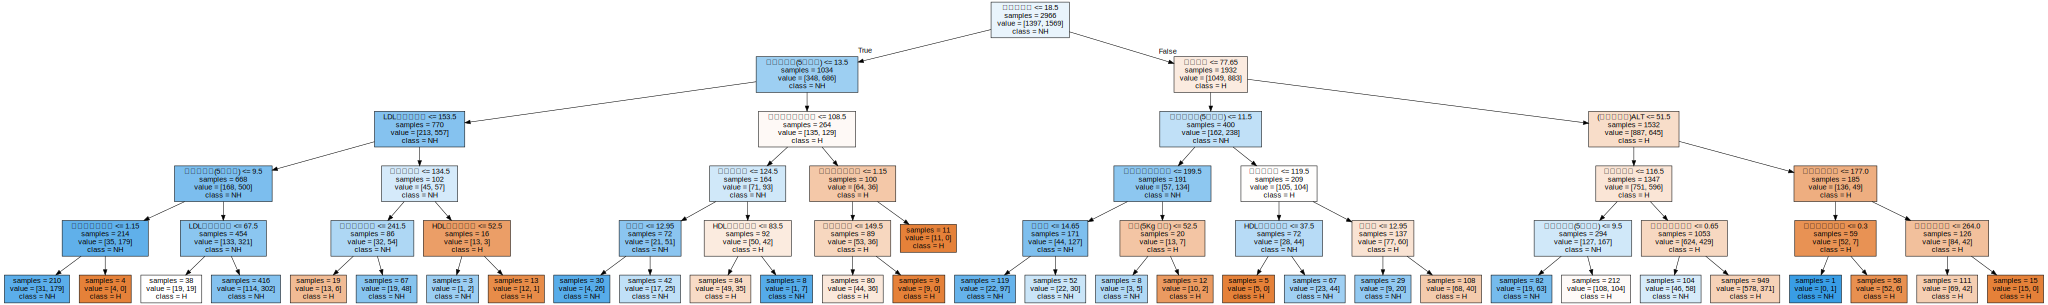

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["H", "NH"],
                feature_names=health.columns[0:23], impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

변수의 중요도 파악

In [ ]:
result = tree.feature_importances_
print("변수의 중요도:\n", result)

변수의 중요도:
 [0.         0.19114849 0.         0.00876863 0.08349227 0.
 0.         0.         0.         0.12313976 0.         0.05321911
 0.04717561 0.03816578 0.04314588 0.04933429 0.         0.06826641
 0.         0.04461627 0.24952751 0.         0.        ]


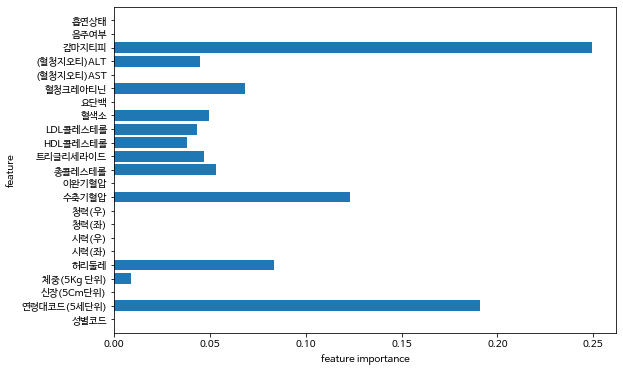

In [ ]:
def plot_feature_importances_wisc(model):
    plt.rcParams["figure.figsize"] = (9,6)
    n_features = len(health.columns[0:23])
    plt.barh(np.arange(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), health.columns[0:23])
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)

plot_feature_importances_wisc(tree)

# 2. 앙상블 모델

(1) 랜덤 포레스트

성능 확인

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(x_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(forest.score(x_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(forest.score(x_test, y_test)))

학습용 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.625


사용된 변수 파악

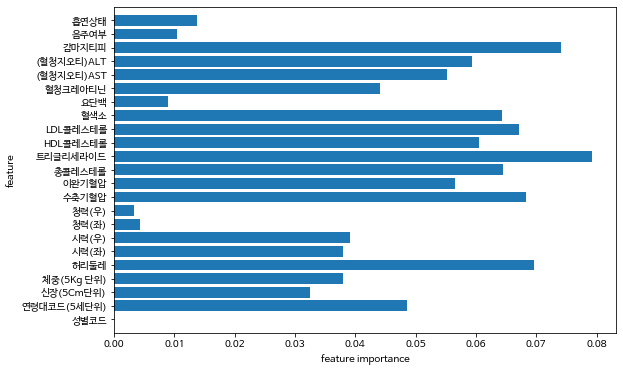

In [ ]:
plot_feature_importances_wisc(forest)

랜덤 포레스트와 의사결정나무 모델 비교

In [ ]:
from sklearn.model_selection import cross_val_score

dt_scores = cross_val_score(tree, x_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, x_train, y_train, cv=10, scoring='accuracy')

print("Accuracy")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 

print("Accuracy mean")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 

Accuracy
Decision tree:  [0.68350168 0.58922559 0.58922559 0.60942761 0.5959596  0.60606061
 0.59121622 0.58783784 0.56756757 0.58108108]
Random forest:  [0.67340067 0.64983165 0.60942761 0.64983165 0.6026936  0.66329966
 0.59121622 0.61824324 0.59797297 0.58783784]
Accuracy mean
Decision tree :0.600
Random forest :0.624


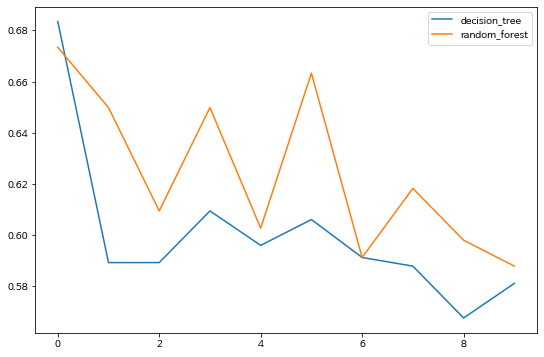

In [ ]:
cv_list = [    
            ['decision_tree',dt_scores],
            ['random_forest',rf_scores],
          ]
df = pd.DataFrame.from_dict(dict(cv_list))
df.plot()

그래프 해석: 일반적으로 의사결정나무보다 랜덤 포레스트의 정확도가 더 높게 나타난다.

(2) 그래디언트 부스팅

성능 확인

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# 기본값은 max_depth= 3, n_estimators=100, learning_rate = 0.1

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(x_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(gbrt.score(x_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(x_test, y_test)))

학습용 데이터 세트 정확도: 0.733
시험용 데이터 세트 정확도: 0.616


In [ ]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=5) 
gbrt.fit(x_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(gbrt.score(x_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(x_test, y_test)))

학습용 데이터 세트 정확도: 0.874
시험용 데이터 세트 정확도: 0.638


사용된 변수 파악

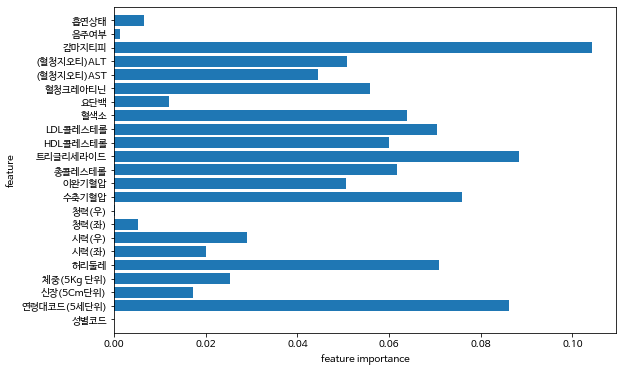

In [ ]:
plot_feature_importances_wisc(gbrt)

# 평가

교차 검증

In [ ]:
dt_scores = cross_val_score(tree, x_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, x_train, y_train, cv=10, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, x_train, y_train, cv=10, scoring='accuracy')

print("Accuracy")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 
print("Gradient boosting: ", gbrt_scores) 

print("Accuracy mean")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean())) 

Accuracy
Decision tree:  [0.68350168 0.58922559 0.58922559 0.60942761 0.5959596  0.60606061
 0.59121622 0.58783784 0.56756757 0.58108108]
Random forest:  [0.67340067 0.64983165 0.60942761 0.64983165 0.6026936  0.66329966
 0.59121622 0.61824324 0.59797297 0.58783784]
Gradient boosting:  [0.65993266 0.60942761 0.58585859 0.61616162 0.60606061 0.62289562
 0.59797297 0.60135135 0.60135135 0.57094595]
Accuracy mean
Decision tree :0.600
Random forest :0.624
Gradient boosting :0.607


In [ ]:
x_test = health.iloc[:, 0:23].values
y_test = health.iloc[:, 23].values

그래디언트 부스팅

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[1,2,3], 'learning_rate':[0.1,0.08, 0.06, 0.04, 0.02]}
init_gbrt = GradientBoostingClassifier(random_state=0)
grid_gbrt = GridSearchCV(init_gbrt, param_grid=parameters, cv=3, refit=True)

grid_gbrt.fit(x_train, y_train)

scores_df = pd.DataFrame(grid_gbrt.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'learning_rate': 0.1, 'max_depth': 1}",0.639236,2,0.658241,0.645096,0.614372
1,"{'learning_rate': 0.1, 'max_depth': 2}",0.633508,4,0.650152,0.631951,0.618421
2,"{'learning_rate': 0.1, 'max_depth': 3}",0.626764,14,0.649141,0.621840,0.609312
3,"{'learning_rate': 0.08, 'max_depth': 1}",0.640924,1,0.653185,0.647118,0.622470
4,"{'learning_rate': 0.08, 'max_depth': 2}",0.630476,9,0.649141,0.620829,0.621457
5,"{'learning_rate': 0.08, 'max_depth': 3}",0.628451,12,0.650152,0.621840,0.613360
6,"{'learning_rate': 0.06, 'max_depth': 1}",0.635869,3,0.641052,0.644085,0.622470
7,"{'learning_rate': 0.06, 'max_depth': 2}",0.632835,5,0.650152,0.626896,0.621457
8,"{'learning_rate': 0.06, 'max_depth': 3}",0.631486,8,0.649141,0.625885,0.619433
9,"{'learning_rate': 0.04, 'max_depth': 1}",0.630475,10,0.631951,0.641052,0.618421


In [ ]:
print('GridSearchCV 최적 파라미터:', grid_gbrt.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_gbrt.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.08, 'max_depth': 1}
GridSearchCV 최고 정확도: 0.6409


In [ ]:
print("시험용 데이터 세트 정확도: {:.3f}".format(grid_gbrt.score(x_test, y_test)))

시험용 데이터 세트 정확도: 0.652


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


평가 지표: 정확도(accuracy)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 

dt_pred = tree.predict(x_test)
rf_pred = forest.predict(x_test)
grid_gbrt_pred = grid_gbrt.predict(x_test)

# 예측 결과인 pred와 실제 결과인 y_test의 Confusion Matrix 출력
print('Decision tree 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, dt_pred)))
print(confusion_matrix(y_test, dt_pred))
print('Random forest 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, rf_pred)))
print(confusion_matrix(y_test, rf_pred))
print('Gradient boosting 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, grid_gbrt_pred)))
print(confusion_matrix(y_test, grid_gbrt_pred))

Decision tree 시험용 데이터 세트 정확도:0.644
[[1375  480]
 [ 927 1173]]
Random forest 시험용 데이터 세트 정확도:0.906
[[1676  179]
 [ 192 1908]]
Gradient boosting 시험용 데이터 세트 정확도:0.652
[[1130  725]
 [ 653 1447]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


-> 랜덤 포레스트 모델의 정확도가 가장 높게 나타나므로, 랜덤 포레스트를 채택한다. 

# 인사이트





*   사용된 변수 파악 시, 트리글리세라이드, 감마지티피, 허리둘레, 수축기혈압, LDL콜레스테롤 변수의 중요성이 크게 나타나고 있다. (Top 5)
*   즉, 트리글리세라이드와 허리둘레, LDL콜레스테롤 수치는 비만과 관련이 있는 변수로, 비만에 해당하는 자는 식전혈당 수치가 높을 가능성이 크므로 유의해야 한다.
*   감마지티피는 간 기능을 나타내는 수치로, 감마지티피의 높은 수치가 높은 식전혈당에 영향을 미친다는 것을 시사한다. 따라서 음주 등 간 기능에 악영향을 줄 수 있는 행위를 조절해야 할 것이다.
*   수축기혈압에 따라, 혈압이 높은 자는 공복혈당장애 혹은 당뇨병을 앓을 확률이 크다.
*   결론적으로, 높은 혈당 수치에 큰 영향을 미치는 변수는 트리글리세라이드, 감마지티피, 허리둘레, 수축기혈압, LDL콜레스테롤 등이 있으며, 식전혈당이 H(High)로 분류 예측되는 사람들은 비만, 음주, 고혈압 등을 앓고 있을 가능성이 큼을 알 수 있다. 
